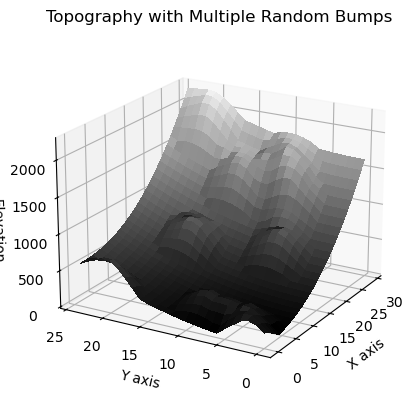

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

from landlab import RasterModelGrid
# from landlab.components import PriorityFloodFlowRouter, ErosionDeposition, FlowAccumulator 
from landlab.components import FastscapeEroder, PriorityFloodFlowRouter, DepressionFinderAndRouter
from landlab.plot.drainage_plot import drainage_plot
import copy
from landlab.plot import imshow_grid

from landlab.components import ChannelProfiler



def surf_plot(mg, surface="topographic__elevation", title="Surface plot of topography"):
    plt.figure()
    ax = plt.axes(projection="3d")
    
    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    color = cm.gray((Z - Z.min()) / (Z.max() - Z.min()))
    ax.plot_surface(
        mg.x_of_node.reshape(mg.shape),
        mg.y_of_node.reshape(mg.shape),
        Z,
        rstride=1,
        cstride=1,
        facecolors=color,
        linewidth=0.0,
        antialiased=False,
    )
    ax.view_init(elev=20, azim=-150)
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Elevation")
    plt.title(title)
    plt.show()

# Create grid
mg = RasterModelGrid((25, 30))
x, y = mg.x_of_node, mg.y_of_node
base_elevation =1.0 + x**2.2 + y**2
mg.add_field("topographic__elevation", base_elevation, at="node")

# Parameters
num_bumps = 10
bump_height = 300
bump_radius = 4  # in grid units
sigma = bump_radius / 2.0

# Randomly choose 10 distinct nodes
#np.random.seed(42)  # For reproducibility (optional)
#raised_nodes = np.random.choice(mg.number_of_nodes, size=num_bumps, replace=False)
raised_nodes = np.array([197, 124, 494, 443,  60, 233, 627, 296, 600, 274])

# Add a Gaussian bump around each raised node
for node in raised_nodes:
    xc, yc = x[node], y[node]
    distances = np.sqrt((x - xc)**2 + (y - yc)**2)
    mask = distances < bump_radius
    bump = bump_height * np.exp(-((distances[mask])**2) / (2 * sigma**2))
    mg.at_node["topographic__elevation"][mask] += bump

# Plot the final terrain
surf_plot(mg, title="Topography with Multiple Random Bumps")

In [ ]:
print("Random node indices:", raised_nodes) #Random node indices: [ 52 679  79 154 203 638 150 409 284 485]
## Random node indices: [ 80 126  79 596 522 179 730 130 288 170]
#Random node indices: [294 405 124  41 351 347 610 123 668 445]
# Random node indices: [197 124 494 443  60 233 627 296 600 274]

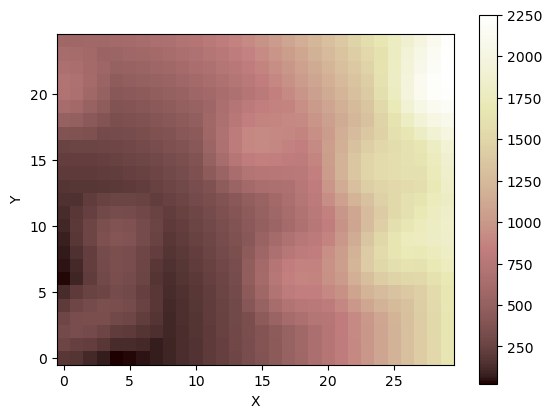

In [2]:
mg.imshow("topographic__elevation")

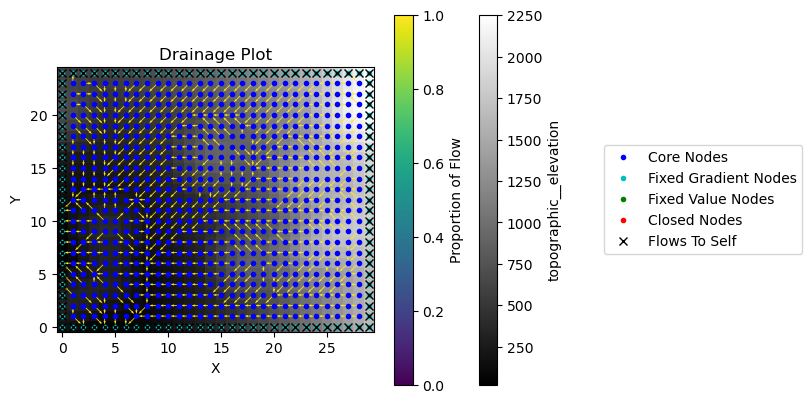

In [3]:
#fa = PriorityFloodFlowRouter(mg)

# # this is the same as writing:
fa = PriorityFloodFlowRouter(
    mg,
    surface="topographic__elevation",
    flow_metric="D8",
    update_flow_depressions=True,
    depression_handler="breach",
 )

fa.run_one_step()
plt.figure()
drainage_plot(mg)

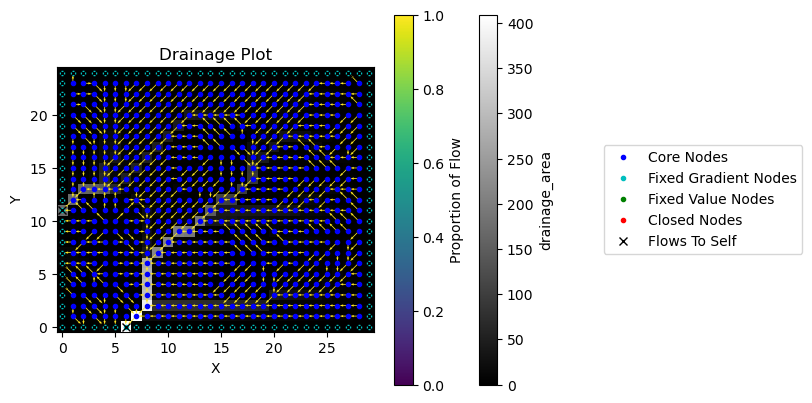

In [4]:
plt.figure()
drainage_plot(mg, "drainage_area")

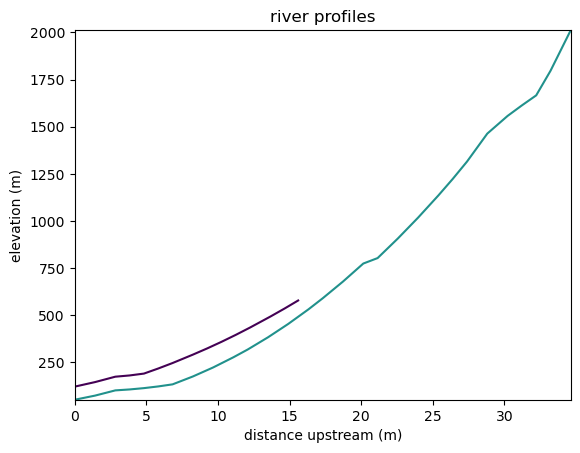

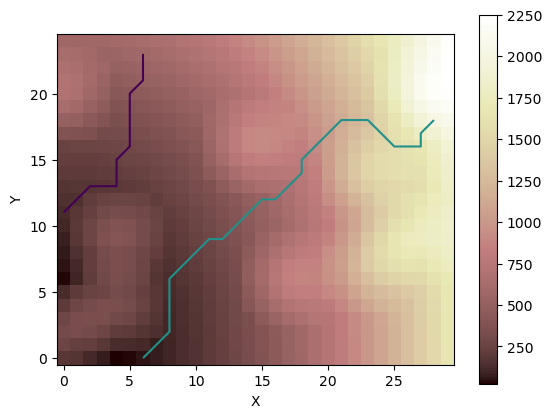

In [5]:
cp = ChannelProfiler(
mg,
channel_definition_field='drainage_area',
number_of_watersheds=2,
main_channel_only=True,
)
cp.run_one_step()
plt.figure(1)
#title_text = f"$K_{{sp}}$={K_sp}; ={total_time} yr; ={dxy} m"
cp.plot_profiles(xlabel="distance upstream (m)", ylabel="elevation (m)", title='river profiles')

plt.figure(2)
cp.plot_profiles_in_map_view()

In [ ]:
df = DepressionFinderAndRouter(mg, reroute_flow=False)
df.map_depressions()
df.display_depression_map()

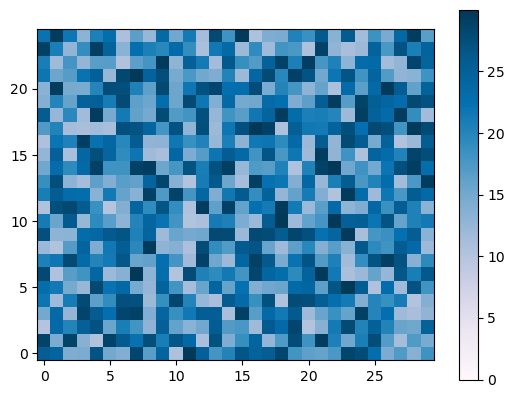

In [6]:
rain = 10.0 + 20.0 * np.random.rand(mg.number_of_nodes)
filtration=np.random.rand(mg.number_of_nodes)
final_flux_in=rain*(1-filtration)
#final_flux_in=0.8*rain

plt.imshow(rain.reshape(mg.shape), origin="lower", cmap="PuBu", vmin=0)
plt.colorbar()
plt.show()

_ = mg.add_field("water__unit_flux_in", final_flux_in, at="node", clobber=True)

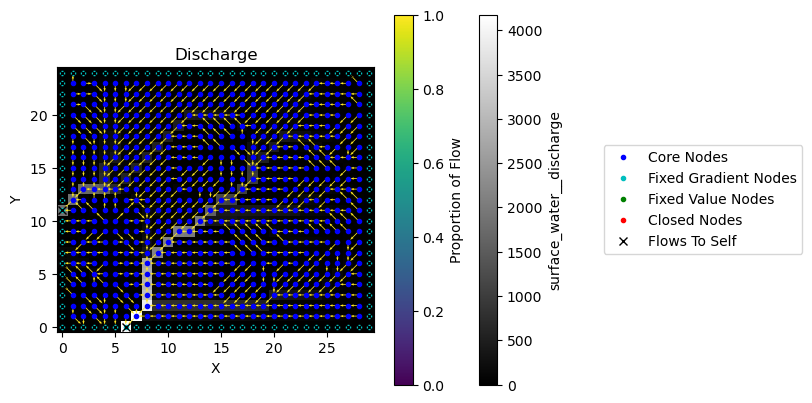

In [7]:
fa.run_one_step()
plt.figure()
drainage_plot(mg, "surface_water__discharge", title="Discharge")

### 250511 1149

In [ ]:
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from landlab import HexModelGrid
from landlab.components import ErosionDeposition, FlowAccumulator, FastscapeEroder
from landlab.plot import imshow_grid

In [8]:
#K_field = mg.ones(at="node")

sp = FastscapeEroder(
    mg,
    K_sp=0.0001, #K_field
    m_sp=0.5, #1.0
    n_sp=1.0, #0.6
    threshold_sp=0.0, #mg.node_x,
    discharge_field="surface_water__discharge",
)

run_duration = 1000.0  # duration of run, yr
dt = 10.0  # time-step duration, yr
plot_every = 100.0  # time interval for plotting, yr

# Derived parameters
nsteps = int(run_duration / dt)
next_plot = plot_every

# set up colormap
cmap = copy.copy(mpl.colormaps["pink"])

In [ ]:
# Parameters for Erosion Deposition - Not using anymore
dx = 100.0
K = 0.0001  # erodibility coefficient, 1/yr
m_sp = 0.5  # exponent on drainage area or discharge, -
n_sp = 1.0  # exponent on slope, -
sp_crit = 0.0  # erosion threshold
v_s = 100.0  # settling velocity parameter (dimensionless if drainage area is used instead of discharge)
F_f = 0.5  # fraction of fines generated during bed erosion


run_duration = 1000.0  # duration of run, yr
dt = 10.0  # time-step duration, yr
plot_every = 100.0  # time interval for plotting, yr

# Derived parameters
nsteps = int(run_duration / dt)
next_plot = plot_every

# set up colormap
cmap = copy.copy(mpl.colormaps["pink"])

In [ ]:
ed = ErosionDeposition(
    mg,
    K=K,
    m_sp=m_sp,
    n_sp=n_sp,
    sp_crit=sp_crit,
    v_s=v_s,
    F_f=F_f,
    solver="adaptive",  # use the adaptive time stepper, which is slightly faster
)

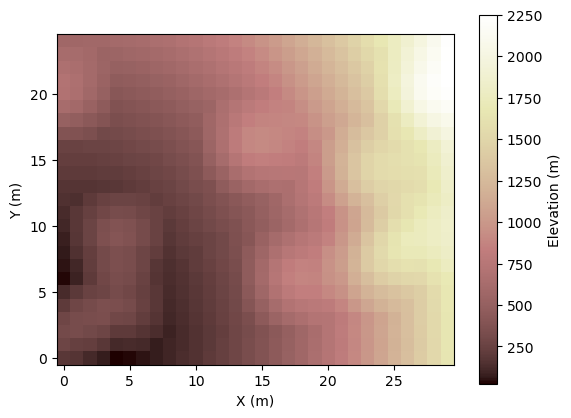

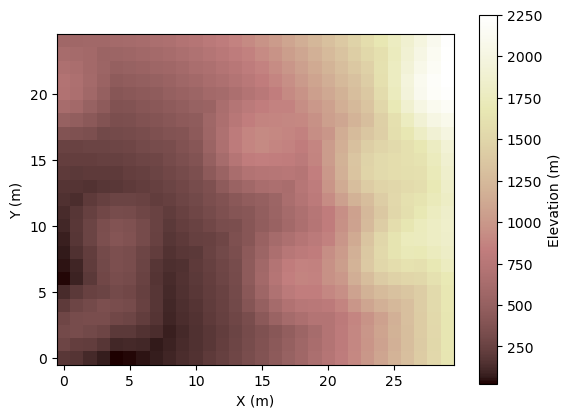

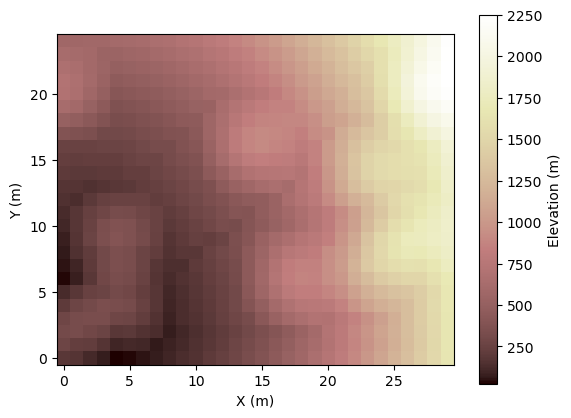

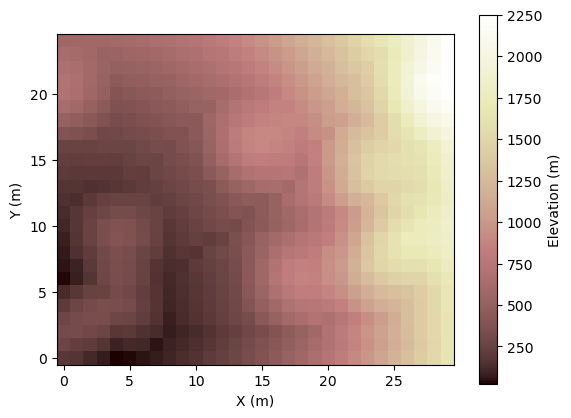

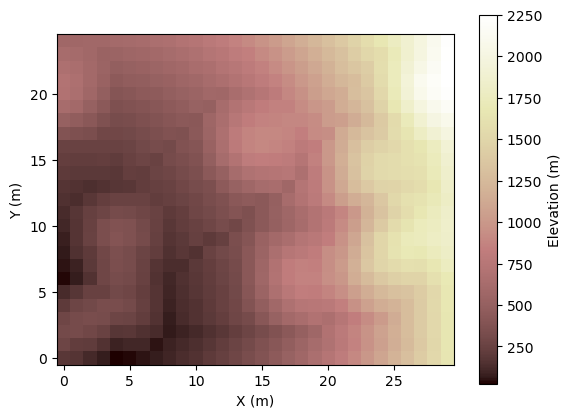

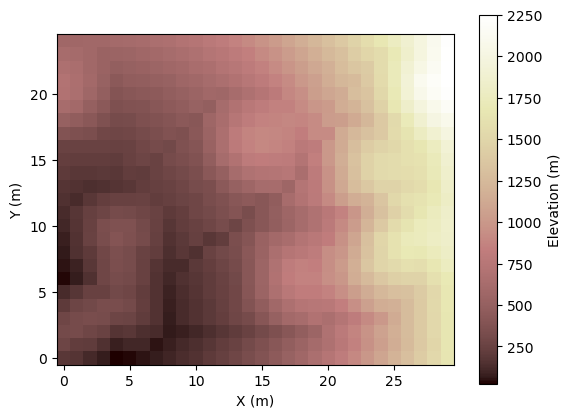

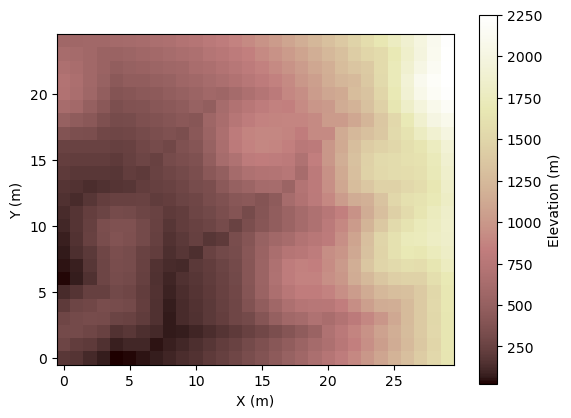

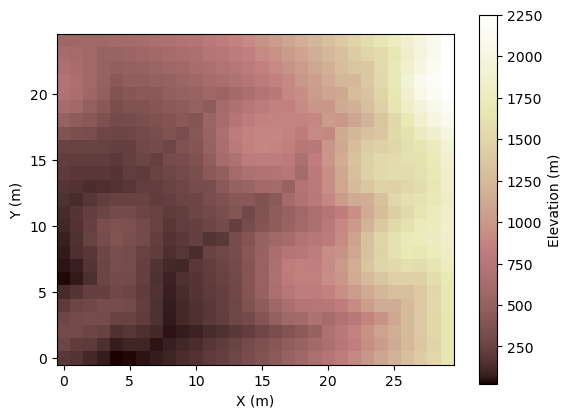

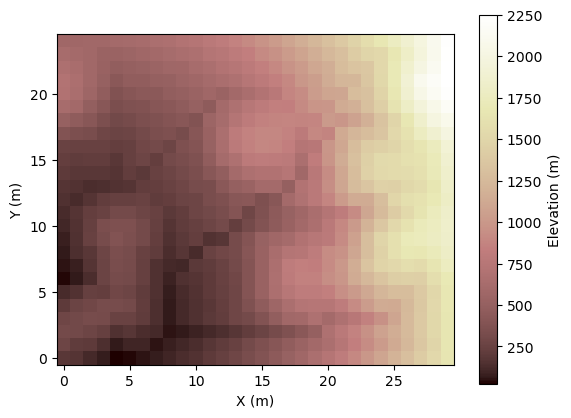

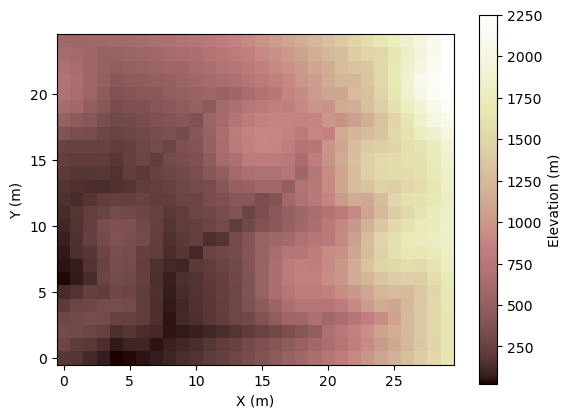

In [9]:
for i in range(1, nsteps + 1):
    # route flow
    fa.run_one_step()  # run_one_step isn't time sensitive, so it doesn't take dt as input

    # do some erosion/deposition
    sp.run_one_step(dt) #(dt=1.0)

    if i * dt >= next_plot:
        plt.figure()
        imshow_grid(
            mg,
            "topographic__elevation",
            grid_units=["m", "m"],
            var_name="Elevation (m)",
            cmap=cmap,
        )
        next_plot += plot_every

In [ ]:
ErosionDeposition.input_var_names

In [ ]:
ErosionDeposition.output_var_names

In [ ]:
FastscapeEroder.input_var_names

In [ ]:
FastscapeEroder.output_var_names

### This could be something cool to show with the streams that are created!

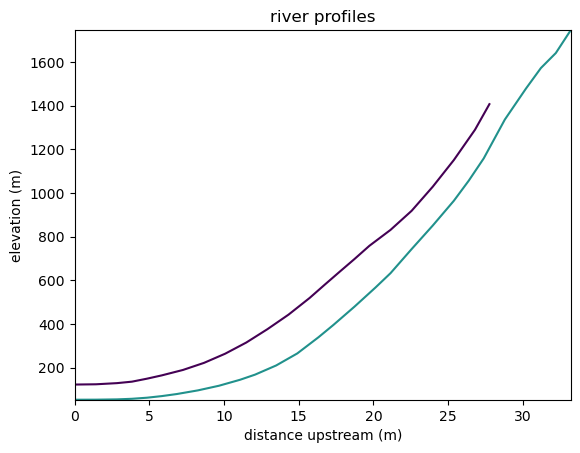

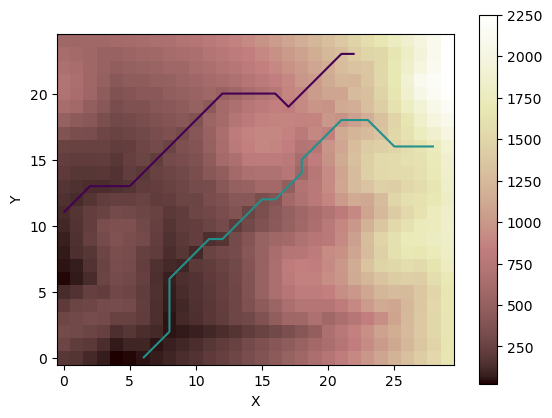

In [12]:
from landlab.components import ChannelProfiler

cp = ChannelProfiler(
mg,
channel_definition_field='drainage_area',
number_of_watersheds=2,
main_channel_only=True,
)
cp.run_one_step()
plt.figure(1)
#title_text = f"$K_{{sp}}$={K_sp}; ={total_time} yr; ={dxy} m"
cp.plot_profiles(xlabel="distance upstream (m)", ylabel="elevation (m)", title='river profiles')

plt.figure(2)
cp.plot_profiles_in_map_view()